# COGS 108 - Data Checkpoint

# Names

- Dina Dehaini
- Cody Maheu
- Ryan Jackson
- Lauren Taylor
- Andrew Karafilis Tremaine

<a id='research_question'></a>
# Research Question

Can the wealth of a country determine whether their agricultural exports will be used as food (finalized goods for humans) or feed (raw product for consumption by animals to produce other goods)?

# Dataset(s)

**Dataset Name:** GDP (Current US$) **(GDP)**
 - **Link to Dataset:** https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?end=2019&name_desc=false&start=1960
 - **Number of observations:** 265
 - **Description:** World Bank national accounts data, and OECD National Accounts data files of countries’ GDP.
     - **Timeline:** 1960-2019
     - Data are in current U.S. dollars

**Dataset Name:** Who eats the food we grow? **(FAO)**
 - **Link to Dataset:** https://www.kaggle.com/dorbicycle/world-foodfeed-production
 - **Number of observations:** 21,477
 - **Description:** “The Food and Agriculture Organization of the United Nations provides free access to food and agriculture data for over 245 countries and territories.” (https://www.kaggle.com/dorbicycle/world-foodfeed-production)  The dataset that we are interested in is the Food Balance Sheets. It has the data of a country's food supply during a specified reference period  specifically in our case food/feed.  
     - **Timeline:** 1961-2013
     - Food - refers to the quantity of the food item available as human food during the reference period.
     - Feed - refers to the quantity of the food item available for feeding to the livestock and poultry during the reference period.

**Combining Data**
 - The data will be merged together based on their country code (Area abbreviation in FAO, Country code in GDP). We will examine the data that cannot be merged by hand.



# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# GDP dataset
gdp = pd.read_csv("GDP.csv")

# Feed vs Food dataset (it's encoded in CP1252...)
fao = pd.read_csv("FAO.csv", encoding="latin1")

# All valid ISO-3166 country codes (for cleaning the GDP dataset)
with open("country_codes.txt", "r") as fh:
    country_codes = set(line[:-1] for line in fh)

# Data Cleaning

Describe your data cleaning steps here.

- The dataset has been read in from CSV files into our Dataframe objects for both FAO and GDP.
- We removed rows from the GDP dataset with invalid country codes.

- We have begun the steps to begin to understand the data and figure out where our data outliers are coming from. (USA skews it heavily.)
- The FAO dataset has no NaN values but GDP has NaN values for years where a given country did not exist (and some years past 2013 for unknown reasons). We will need to factor this in when merging the datasets.


In [2]:
# Dumping the columns for reference
gdp.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'Unnamed: 65'],
      dtype='object')

In [3]:
# Dumping the columns for reference
fao.columns

Index(['Area Abbreviation', 'Area Code', 'Area', 'Item Code', 'Item',
       'Element Code', 'Element', 'Unit', 'latitude', 'longitude', 'Y1961',
       'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967', 'Y1968', 'Y1969',
       'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975', 'Y1976', 'Y1977',
       'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983', 'Y1984', 'Y1985',
       'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991', 'Y1992', 'Y1993',
       'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999', 'Y2000', 'Y2001',
       'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007', 'Y2008', 'Y2009',
       'Y2010', 'Y2011', 'Y2012', 'Y2013'],
      dtype='object')

In [4]:
# Remove any countries from the GDP dataset that aren't in the FAO dataset.
# Also ensure they're all valid country codes -- there are several
# "total" rows that sum together multiple countries in the GDP dataset.
fao_countries = set(fao["Area Abbreviation"])
valid_countries = fao_countries & country_codes
gdp = gdp[[country in valid_countries for country in gdp["Country Code"]]]

# Year, Country Code, Tons of Food, Tons of Feed, Real GDP
data = pd.DataFrame(columns=["year", "country", "food", "feed", "gdp"])

START = 1961
END = 2013

for year in range(START, END + 1):
    # Convert from thousands of tons to tons
    food_totals = fao[fao["Element"] == "Food"].groupby(["Area Abbreviation"])["Y%d" % year].sum() * 1000
    feed_totals = fao[fao["Element"] == "Feed"].groupby(["Area Abbreviation"])["Y%d" % year].sum() * 1000

    for _, country in gdp.iterrows():
        gdp_for_year = country[str(year)]
        food_for_year = food_totals[country["Country Code"]]

        # Throw out unless we have both GDP data and food export data for the year
        # (feed export data can be 0)
        if not np.isnan(gdp_for_year) and food_for_year > 0:
            data = data.append({
                "year": year,
                "country": country["Country Code"],
                "food": food_for_year,
                "feed": feed_totals[country["Country Code"]],
                "gdp": gdp_for_year
            }, ignore_index=True)

In [5]:
# Dictionary to convert from country codes to full name
country_names = dict(zip(gdp["Country Code"], gdp["Country Name"]))

# Data Analysis & Results (EDA)

In [6]:
latest = data[data["year"] == 2013]

In [7]:
# Show the top and bottom 10 countries by GDP in 2013.
out = latest.sort_values("gdp", ascending=False)
out["country"] = out["country"].apply(lambda x: country_names[x])

In [8]:
out.head(n=10)

,year,country,food,feed,gdp
7036,2013,United States,6.417760e+08,296863000.0,1.678485e+13
6908,2013,China,2.541768e+09,702607000.0,9.570406e+12
6957,2013,Japan,1.531610e+08,34952000.0,5.155717e+12
6918,2013,Germany,1.584730e+08,60418000.0,3.732743e+12
6931,2013,France,1.205420e+08,45537000.0,2.811078e+12
6933,2013,United Kingdom,1.229460e+08,27033000.0,2.786023e+12
6900,2013,Brazil,3.124880e+08,127479000.0,2.472807e+12
7008,2013,Russian Federation,2.538920e+08,117021000.0,2.292473e+12
6954,2013,Italy,1.211630e+08,32287000.0,2.141315e+12
6948,2013,India,1.238335e+09,98258000.0,1.856722e+12


In [9]:
out.tail(n=10)

,year,country,food,feed,gdp
6886,2013,Antigua and Barbuda,119000.0,0.0,1.181448e+09
6938,2013,Guinea-Bissau,1220000.0,10000.0,1.046087e+09
6940,2013,Grenada,122000.0,28000.0,8.426201e+08
6963,2013,St. Kitts and Nevis,56000.0,0.0,8.397741e+08
7041,2013,Vanuatu,370000.0,12000.0,8.017876e+08
7042,2013,Samoa,329000.0,8000.0,7.700217e+08
7038,2013,St. Vincent and the Grenadines,158000.0,63000.0,7.212074e+08
6920,2013,Dominica,138000.0,41000.0,4.982963e+08
7017,2013,Sao Tome and Principe,251000.0,0.0,3.005538e+08
6962,2013,Kiribati,135000.0,0.0,1.851139e+08


In [10]:
# Show the top and bottom 10 countries by food export in 2013.
out = latest.sort_values("food", ascending=False)
out["country"] = out["country"].apply(lambda x: country_names[x])

In [11]:
out.head(n=10)

,year,country,food,feed,gdp
6908,2013,China,2.541768e+09,702607000.0,9.570406e+12
6948,2013,India,1.238335e+09,98258000.0,1.856722e+12
7036,2013,United States,6.417760e+08,296863000.0,1.678485e+13
6900,2013,Brazil,3.124880e+08,127479000.0,2.472807e+12
7008,2013,Russian Federation,2.538920e+08,117021000.0,2.292473e+12
6947,2013,Indonesia,2.378260e+08,19062000.0,9.125241e+11
6992,2013,Nigeria,2.288770e+08,72046000.0,5.086930e+11
6999,2013,Pakistan,1.809940e+08,9511000.0,2.312186e+11
6979,2013,Mexico,1.665910e+08,43530000.0,1.274443e+12
6918,2013,Germany,1.584730e+08,60418000.0,3.732743e+12


In [12]:
out.tail(n=10)

,year,country,food,feed,gdp
7042,2013,Samoa,329000.0,8000.0,7.700217e+08
7017,2013,Sao Tome and Principe,251000.0,0.0,3.005538e+08
6969,2013,St. Lucia,216000.0,13000.0,1.664817e+09
7038,2013,St. Vincent and the Grenadines,158000.0,63000.0,7.212074e+08
6920,2013,Dominica,138000.0,41000.0,4.982963e+08
6962,2013,Kiribati,135000.0,0.0,1.851139e+08
6940,2013,Grenada,122000.0,28000.0,8.426201e+08
6886,2013,Antigua and Barbuda,119000.0,0.0,1.181448e+09
6898,2013,Bermuda,103000.0,3000.0,6.465756e+09
6963,2013,St. Kitts and Nevis,56000.0,0.0,8.397741e+08


In [13]:
# Show the top and bottom 10 countries by feed export in 2013.
out = latest.sort_values("feed", ascending=False)
out["country"] = out["country"].apply(lambda x: country_names[x])

In [14]:
out.head(n=10)

,year,country,food,feed,gdp
6908,2013,China,2.541768e+09,702607000.0,9.570406e+12
7036,2013,United States,6.417760e+08,296863000.0,1.678485e+13
6900,2013,Brazil,3.124880e+08,127479000.0,2.472807e+12
7008,2013,Russian Federation,2.538920e+08,117021000.0,2.292473e+12
6948,2013,India,1.238335e+09,98258000.0,1.856722e+12
7034,2013,Ukraine,7.958000e+07,74170000.0,1.833101e+11
6992,2013,Nigeria,2.288770e+08,72046000.0,5.086930e+11
6918,2013,Germany,1.584730e+08,60418000.0,3.732743e+12
6926,2013,Spain,8.105100e+07,56543000.0,1.354757e+12
6905,2013,Canada,6.789300e+07,52274000.0,1.847209e+12


In [15]:
out.tail(n=10)

,year,country,food,feed,gdp
6971,2013,Lesotho,1801000.0,2000.0,2.421470e+09
6904,2013,Central African Republic,4185000.0,2000.0,1.691544e+09
6962,2013,Kiribati,135000.0,0.0,1.851139e+08
7017,2013,Sao Tome and Principe,251000.0,0.0,3.005538e+08
6886,2013,Antigua and Barbuda,119000.0,0.0,1.181448e+09
6978,2013,Maldives,559000.0,0.0,3.295011e+09
7013,2013,Solomon Islands,727000.0,0.0,1.284699e+09
7009,2013,Rwanda,18547000.0,0.0,7.819538e+09
6919,2013,Djibouti,791000.0,0.0,2.042817e+09
6963,2013,St. Kitts and Nevis,56000.0,0.0,8.397741e+08


In [16]:
#latest = data[data["year"] == 1961]

<AxesSubplot:xlabel='gdp', ylabel='Density'>

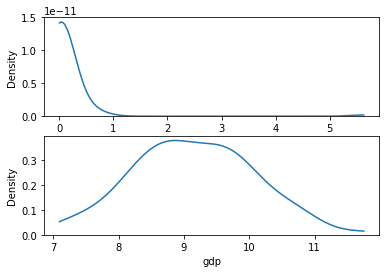

In [17]:
# Normal and log-scale plots of the distribution of GDP
# Average is a "10 figure" GDP from reading the log plot
_, (normal, log) = plt.subplots(2)

sns.kdeplot(latest["gdp"], cut=0, ax=normal)
sns.kdeplot(np.log10(latest["gdp"]), cut=0, ax=log)

<AxesSubplot:xlabel='food', ylabel='Density'>

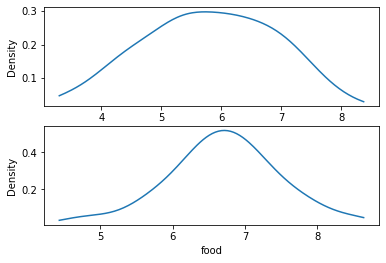

In [18]:
# Log-scale plots of the distribution of total feed exported and total food exported in 2013
# Measured in tons
_, (feed, food) = plt.subplots(2)
sns.kdeplot(np.log10(latest[latest["feed"] > 0]["feed"]), cut=0, ax=feed)
sns.kdeplot(np.log10(latest["food"]), cut=0, ax=food)

In [19]:
# All countries that exported no feed in 2013
out = latest[latest["feed"] <= 0][:]
out["country"] = out["country"].apply(lambda x: country_names[x])

out

,year,country,food,feed,gdp
6,1961,Bermuda,67000.0,0.0,8.924999e+07
10,1961,Central African Republic,2152000.0,0.0,1.231346e+08
17,1961,"Congo, Dem. Rep.",1373000.0,0.0,3.086747e+09
45,1961,St. Kitts and Nevis,27000.0,0.0,1.248323e+07
67,1961,Rwanda,3915000.0,0.0,1.220000e+08
74,1961,Togo,1673000.0,0.0,1.263965e+08


# Project Proposal (updated)

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/11  | 4 PM  | Checkpoint 1 Review | Wrangle data |
| 2/14  | 2 PM  | EDA stuff | start checkpoint 2 |
| 2/17  | 4 PM  | prep checkpoint 2 turnin | turn checkpoint 2 in |
| 2/21  | 2 PM  | talk about data analysis | data analysis |
| 2/24  | 4 PM  | more data analysis, clean up notebook | review notebook |
